In [ ]:
from data_reader import read_gaze_data_csv_file as read_gaze
f_name = "./asterix/160_RZ_9166697_Feb-20-16-46-45.txt"

gazepositions, frameid2action, \
frameid2duration, frameid2unclipped_reward, frameid2episode, \
frameid2score, frameid_list = read_gaze(f_name)

In [ ]:
from scipy import ndimage as ndi
import numpy as np
from imageio import imwrite

# 0.40 visual degrees = 2.94 pixels (Zhang et al. 2019, p. 3)
# 1 visual degree = 7.35 pixels or, rounded, 7 pixels

def check_gaze_range(pos_x, pos_y, w=160, h=210):
    """ Check if the gaze coordinate is within the screen """
    if pos_x < 0 or pos_x > w or pos_y < 0 or pos_y > h:
        return False
    return True

for frame_id in frameid_list:
    gaze_list = gazepositions[frame_id]
    heatmap = np.zeros((160, 210))
    if gaze_list is not None and len(gaze_list) > 0:
        for (x, y) in gaze_list:
            if check_gaze_range(x, y):
                heatmap[int(x - 1), int(y - 1)] = 1

    heatmap = ndi.gaussian_filter(heatmap.T, sigma=7) # sigma should be one visual degree
    heatmap = np.interp(heatmap, (heatmap.min(), heatmap.max()), (0, 255)) # change values range from {0,1} to {0, 255}
    imwrite(f"./asterix/heatmaps/{frame_id}.png", heatmap.astype(np.uint8))

In [10]:
import os

files = os.listdir("./asterix/heatmaps")
len(files) == len(set(frameid_list)) # check if there is a heatmap for every frame

True

Found 15515 files belonging to 1 classes.
Using 12412 files for training.
Found 15515 files belonging to 1 classes.
Using 12412 files for training.
Found 15515 files belonging to 1 classes.
Using 3103 files for validation.
Found 15515 files belonging to 1 classes.
Using 3103 files for validation.
(32, 84, 84, 1) (32, 84, 84, 1)


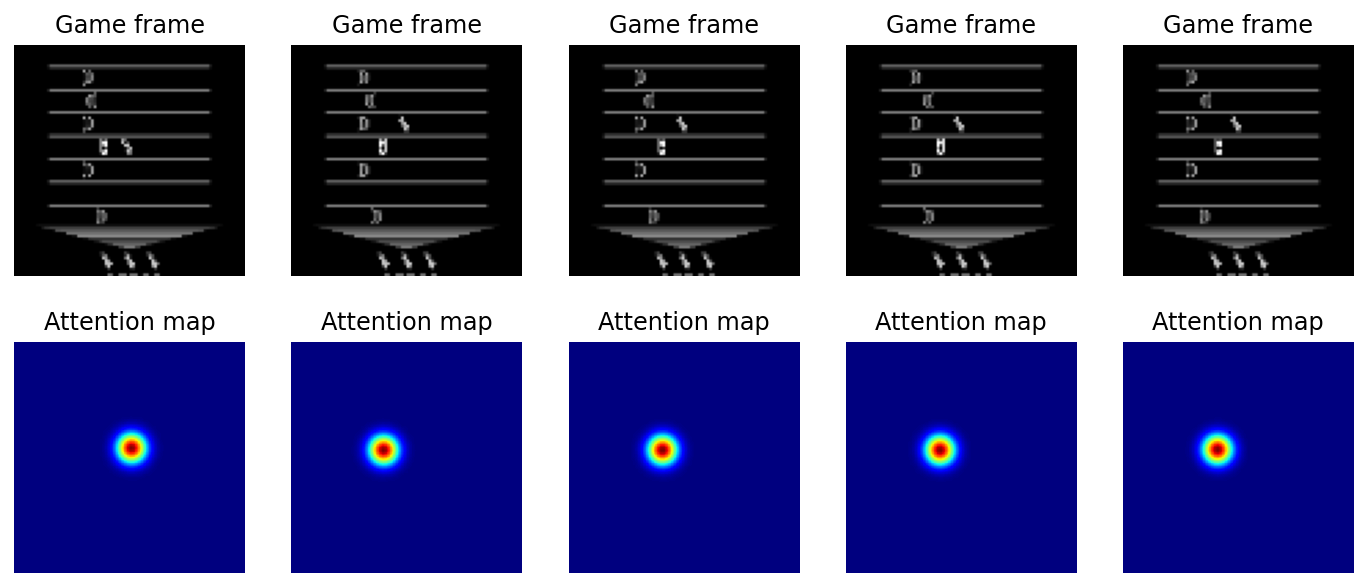

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

frames_dir = "./asterix/frames"
labels_dir = "./asterix/heatmaps"

train_frames = tf.keras.utils.image_dataset_from_directory(
  frames_dir,
  labels=None,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=32,
  color_mode='grayscale',
  crop_to_aspect_ratio=True,
)

train_labels = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  labels=None,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=32,
  color_mode='grayscale',
  crop_to_aspect_ratio=True,
)

val_frames = tf.keras.utils.image_dataset_from_directory(
  frames_dir,
  labels=None,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=32,
  color_mode='grayscale',
  crop_to_aspect_ratio=True,
)

val_labels = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  labels=None,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(84, 84),
  shuffle=False,
  batch_size=32,
  color_mode='grayscale',
  crop_to_aspect_ratio=True,
)
        
train_ds = tf.data.Dataset.zip((train_frames, train_labels))
val_ds = tf.data.Dataset.zip((val_frames, val_labels))

for frames, labels in train_ds.take(1):
    print(frames.shape, labels.shape)
        
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
ax = ax.ravel()
for frames, labels in val_ds.take(1):
    for i in range(5):
        ax[i].imshow(frames[i].numpy().astype("uint8"), cmap='gray')
        ax[i].set_title('Game frame')
        ax[i].axis("off")

    for i in range(5, 10):
        ax[i].imshow(labels[i].numpy().astype("uint8"), cmap='jet')
        ax[i].set_title('Attention map')  
        ax[i].axis("off")

In [5]:
@tf.function
def train_step(model, inputs, targets, loss_fn, optimiser, loss_metric):
    print(model, inputs, targets, loss_fn, optimiser, loss_metric)
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        print(predictions.shape)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs
    
@tf.function
def test_step(inputs, targets, loss_fn, loss_metric):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    loss_metric.update_state(loss)
    logs["val_loss"] = loss_metric.result()
    return logs, predictions

In [ ]:
import tensorflow as tf
from model import GazePrediction
import gym
from gym.wrappers import FrameStack, AtariPreprocessing
import numpy as np
from tensorflow.keras.optimizers import Adam

env = gym.make('ALE/Asterix-v5', frameskip=1)
env = AtariPreprocessing(env, frame_skip=4)
# frame stacking with 4 frames
env = FrameStack(env, num_stack=4)

tf.keras.backend.clear_session()

# Hyperparameters
epochs = 10
learning_rate = 0.001

# Initialize the model
model = GazePrediction(env)
loss_fn = tf.keras.losses.KLDivergence()
optimiser = Adam(learning_rate=learning_rate)

# Metrics
loss_metric = tf.keras.metrics.KLDivergence()
hist = {'loss': [], 'val_loss': []}


def reset_metrics(metrics):
    """Utility function to reset the state of metrics"""
    for metric in metrics:
        metric.reset_state()

examples = {"prediction": [], "target": []}

# training
for epoch in range(epochs):
    reset_metrics([loss_metric])
    for inputs, targets in train_ds:
        logs = train_step(model, inputs, targets, loss_fn, optimiser, loss_metric)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")

    # test
    reset_metrics([loss_metric])
    for inputs, targets in val_ds:
        logs, predictions = test_step(inputs, targets, loss_fn, loss_metric)
    id = np.random.randint(12)
    examples["prediction"].append(predictions[id])
    examples["target"].append(targets[id])
    print("...Evaluation results:")
    for key, value in logs.items():
        hist[key].append(value)
        print(f"...{key}: {value:.4f}")
    print("\n")